#  <center> Speech Emotion Recognition <center>



#### Datasets used in this project
* Ryerson Audio-Visual Database of Emotional Speech and Song (Ravdess)


# Importing Libraries

In [ ]:
!pip install tensorflow==2.5

In [ ]:
import pandas as pd
import numpy as np

import os
import sys

# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
from IPython.display import Audio

import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip ravdess-emotional-speech-audio.zip -d /content/ravdess_data

Archive:  ravdess-emotional-speech-audio.zip
  inflating: /content/ravdess_data/Actor_01/03-01-01-01-01-01-01.wav  
  inflating: /content/ravdess_data/Actor_01/03-01-01-01-01-02-01.wav  
  inflating: /content/ravdess_data/Actor_01/03-01-01-01-02-01-01.wav  
  inflating: /content/ravdess_data/Actor_01/03-01-01-01-02-02-01.wav  
  inflating: /content/ravdess_data/Actor_01/03-01-02-01-01-01-01.wav  
  inflating: /content/ravdess_data/Actor_01/03-01-02-01-01-02-01.wav  
  inflating: /content/ravdess_data/Actor_01/03-01-02-01-02-01-01.wav  
  inflating: /content/ravdess_data/Actor_01/03-01-02-01-02-02-01.wav  
  inflating: /content/ravdess_data/Actor_01/03-01-02-02-01-01-01.wav  
  inflating: /content/ravdess_data/Actor_01/03-01-02-02-01-02-01.wav  
  inflating: /content/ravdess_data/Actor_01/03-01-02-02-02-01-01.wav  
  inflating: /content/ravdess_data/Actor_01/03-01-02-02-02-02-01.wav  
  inflating: /content/ravdess_data/Actor_01/03-01-03-01-01-01-01.wav  
  inflating: /content/ravdess_da

In [ ]:
# Define dataset path - update this to your Drive path
DATASET_ROOT = '/content/drive/MyDrive/ravdess_data/audio_speech_actors_01-24'
def setup_data_path():
    """Initialize dataset path and verify existence"""
    if not os.path.exists(DATASET_ROOT):
        raise FileNotFoundError("Dataset directory not found. Please ensure the RAVDESS dataset is in your Drive")
    return DATASET_ROOT
dataset_path = setup_data_path()

## Data Preparation


## **1. RAVDESS Dataset: Filename Structure**

The filenames in the RAVDESS dataset are designed to convey detailed information about each recording. Below is a breakdown of the identifiers used:

---

### **Modality**
Defines the type of data included in the recording:  
- **01**: Audio and video (full AV)  
- **02**: Video only  
- **03**: Audio only  

---

### **Vocal Channel**
Specifies whether the recording features:  
- **01**: Spoken words  
- **02**: Singing  

---

### **Emotion**
Indicates the emotional expression:  
- **01**: Neutral  
- **02**: Calm  
- **03**: Happy  
- **04**: Sad  
- **05**: Angry  
- **06**: Fearful  
- **07**: Disgusted  
- **08**: Surprised  

---

### **Emotional Intensity**
Denotes the level of emotional expression:  
- **01**: Normal intensity  
- **02**: High intensity  
  - *Note: The "neutral" emotion is only available in normal intensity.*

---

### **Statement**
Represents the sentence spoken in the recording:  
- **01**: "Kids are talking by the door."  
- **02**: "Dogs are sitting by the door."  

---

### **Repetition**
Indicates how many times the statement was recorded:  
- **01**: First recording  
- **02**: Second recording  

---

### **Actor**
Identifies the performer of the recording:  
- Actors are numbered **01 to 24**.  
  - Odd numbers: **Male actors**  
  - Even numbers: **Female actors**

---



In [ ]:
def process_audio_files(base_dir):
    """Process audio files and extract emotion labels"""
    emotion_mapping = {
        '01': 'neutral',
        '02': 'calm',
        '03': 'happy',
        '04': 'sad',
        '05': 'angry',
        '06': 'fear',
        '07': 'disgust',
        '08': 'surprise'
    }

    file_data = []
    for actor_dir in os.listdir(base_dir):
        actor_path = os.path.join(base_dir, actor_dir)
        if os.path.isdir(actor_path):
            for audio_file in os.listdir(actor_path):
                if audio_file.endswith('.wav'):
                    parts = audio_file.split('-')
                    emotion_code = parts[2]
                    emotion = emotion_mapping.get(emotion_code)
                    if emotion:
                        file_data.append({
                            'Emotions': emotion,
                            'Path': os.path.join(actor_path, audio_file)
                        })

    return pd.DataFrame(file_data)

# dataframe Creation
Ravdess_df = process_audio_files(dataset_path)
Ravdess_df.head()

<ipython-input-19-a0808166368c>:23: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  Ravdess_df.Emotions.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)


Emotions                                               Path
0       sad  /content/ravdess_data/audio_speech_actors_01-2...
1      calm  /content/ravdess_data/audio_speech_actors_01-2...
2       sad  /content/ravdess_data/audio_speech_actors_01-2...
3     angry  /content/ravdess_data/audio_speech_actors_01-2...
4  surprise  /content/ravdess_data/audio_speech_actors_01-2...

In [ ]:
Ravdess_df

Emotions                                               Path
0          sad  /content/ravdess_data/audio_speech_actors_01-2...
1         calm  /content/ravdess_data/audio_speech_actors_01-2...
2          sad  /content/ravdess_data/audio_speech_actors_01-2...
3        angry  /content/ravdess_data/audio_speech_actors_01-2...
4     surprise  /content/ravdess_data/audio_speech_actors_01-2...
...        ...                                                ...
1435   disgust  /content/ravdess_data/audio_speech_actors_01-2...
1436      calm  /content/ravdess_data/audio_speech_actors_01-2...
1437  surprise  /content/ravdess_data/audio_speech_actors_01-2...
1438   disgust  /content/ravdess_data/audio_speech_actors_01-2...
1439      calm  /content/ravdess_data/audio_speech_actors_01-2...

[1440 rows x 2 columns]

In [ ]:
Ravdess_df
Ravdess_df.to_csv("data_path.csv",index=False)
Ravdess_df.head()

Emotions                                               Path
0       sad  /content/ravdess_data/audio_speech_actors_01-2...
1      calm  /content/ravdess_data/audio_speech_actors_01-2...
2       sad  /content/ravdess_data/audio_speech_actors_01-2...
3     angry  /content/ravdess_data/audio_speech_actors_01-2...
4  surprise  /content/ravdess_data/audio_speech_actors_01-2...

In [ ]:
data_path = pd.read_csv("data_path.csv")
data_path.head()

Emotions                                               Path
0       sad  /content/ravdess_data/audio_speech_actors_01-2...
1      calm  /content/ravdess_data/audio_speech_actors_01-2...
2       sad  /content/ravdess_data/audio_speech_actors_01-2...
3     angry  /content/ravdess_data/audio_speech_actors_01-2...
4  surprise  /content/ravdess_data/audio_speech_actors_01-2...

## Data Visualisation and Exploration

In [ ]:
class AudioVisualizer:
    def __init__(self, data_df):
        self.data_df = data_df

    def plot_emotion_distribution(self):
        plt.figure(figsize=(12, 6))
        plt.title('Count of Emotions', size=16)
        sns.countplot(data=self.data_df, x='Emotions', palette='viridis')
        plt.ylabel('Count', size=12)
        plt.xlabel('Emotions', size=12)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

    def create_waveplot(self, data, sr, emotion):
        plt.figure(figsize=(12, 4))
        plt.title(f'Waveplot for audio with {emotion} emotion', size=15)
        librosa.display.waveshow(data, sr=sr, alpha=0.8)
        plt.tight_layout()
        plt.show()

    def create_spectrogram(self, data, sr, emotion):
        D = librosa.stft(data)
        DB = librosa.amplitude_to_db(abs(D), ref=np.max)
        plt.figure(figsize=(12, 4))
        plt.title(f'Spectrogram for audio with {emotion} emotion', size=15)
        librosa.display.specshow(DB, sr=sr, x_axis='time', y_axis='hz')
        plt.colorbar(format='%+2.0f dB')
        plt.tight_layout()
        plt.show()

    def analyze_emotion(self, emotion):
        path = np.random.choice(
            self.data_df[self.data_df.Emotions == emotion]['Path'].values
        )
        data, sr = librosa.load(path)
        self.create_waveplot(data, sr, emotion)
        self.create_spectrogram(data, sr, emotion)
        return Audio(path)

In [ ]:
visualizer = AudioVisualizer(Ravdess_df)

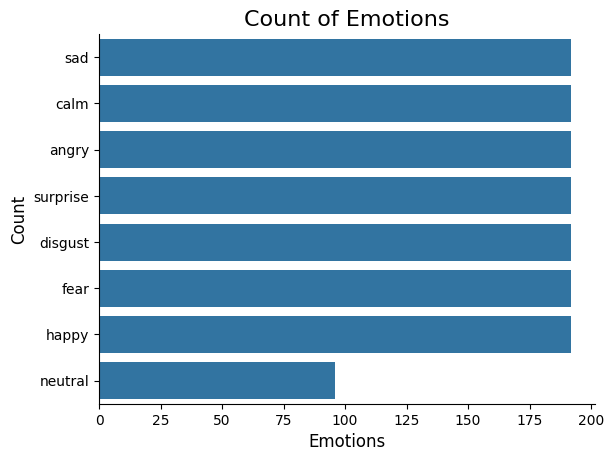

In [ ]:
visualizer.plot_emotion_distribution()

In [ ]:
!pip install --upgrade librosa
import librosa
import librosa.display
# librosa.display.waveshow(y, sr=sr)

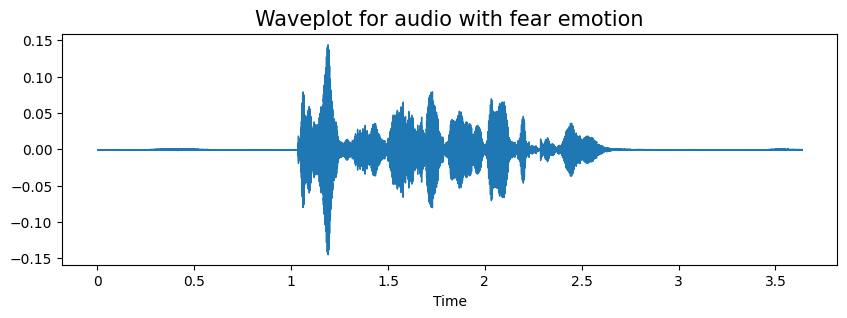

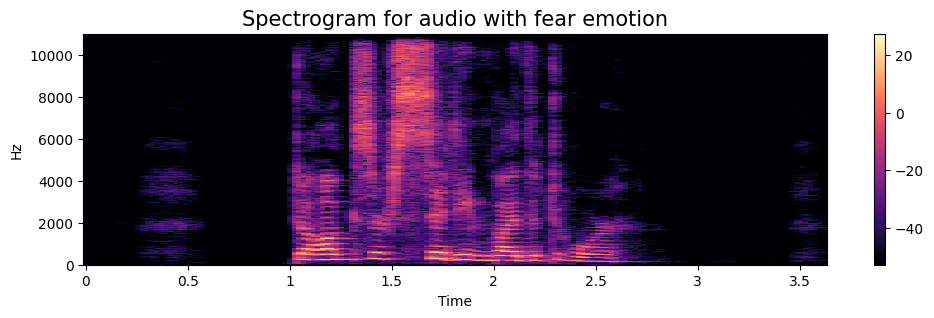

In [ ]:
# Analyze fear emotion
visualizer.analyze_emotion('fear')

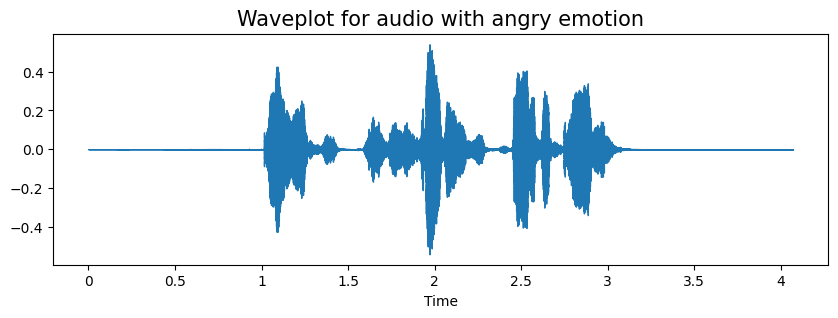

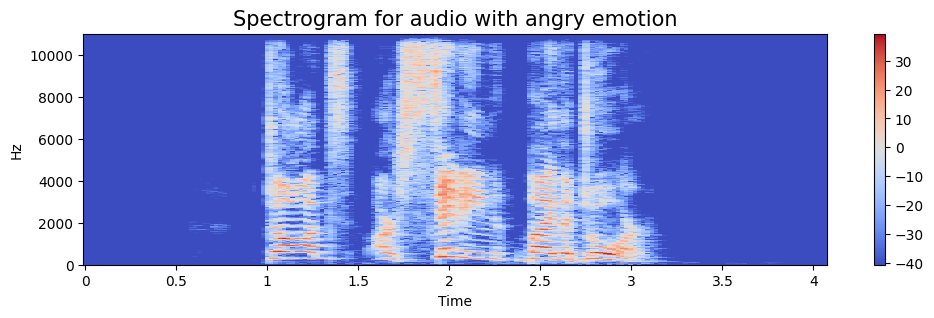

In [ ]:
visualizer.analyze_emotion('angry')

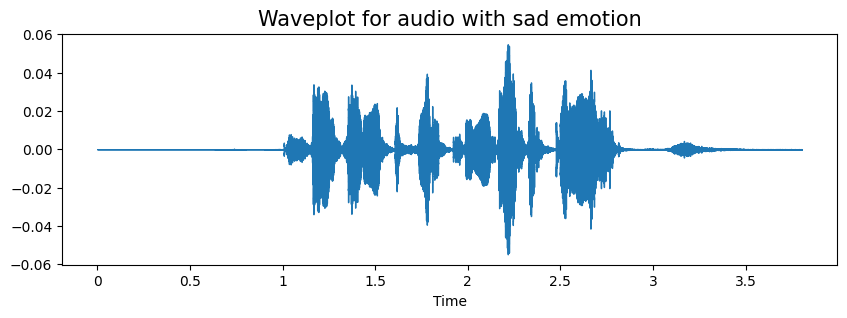

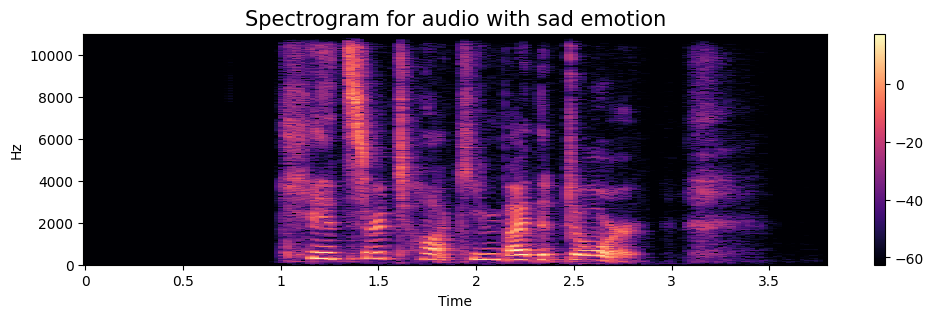

In [ ]:
visualizer.analyze_emotion('sad')

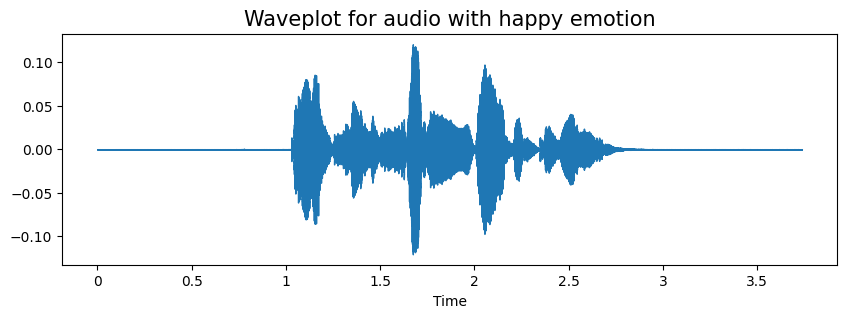

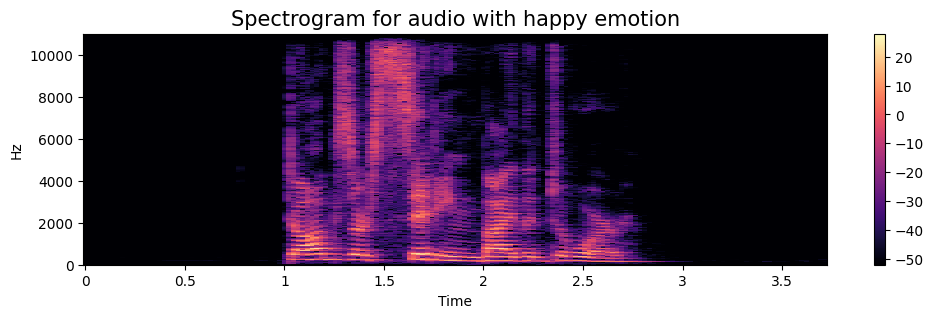

In [ ]:
visualizer.analyze_emotion('happy')

## Data Augmentation



In [ ]:
# Cell 11: Define AudioAugmenter Class
class AudioAugmenter:
    def __init__(self):
        self.noise_factor = 0.035
        self.stretch_factor = 0.8
        self.pitch_factor = 0.7

    def add_noise(self, data):
        noise = self.noise_factor * np.random.normal(size=data.shape[0])
        return data + noise

    def stretch_audio(self, data):
        return librosa.effects.time_stretch(y=data, rate=self.stretch_factor)

    def shift_pitch(self, data, sr):
        return librosa.effects.pitch_shift(y=data, sr=sr, n_steps=self.pitch_factor)

In [ ]:
augmenter = AudioAugmenter()
path = np.array(Ravdess_df.Path)[1]
data, sample_rate = librosa.load(path)

#### 1. Simple Audio

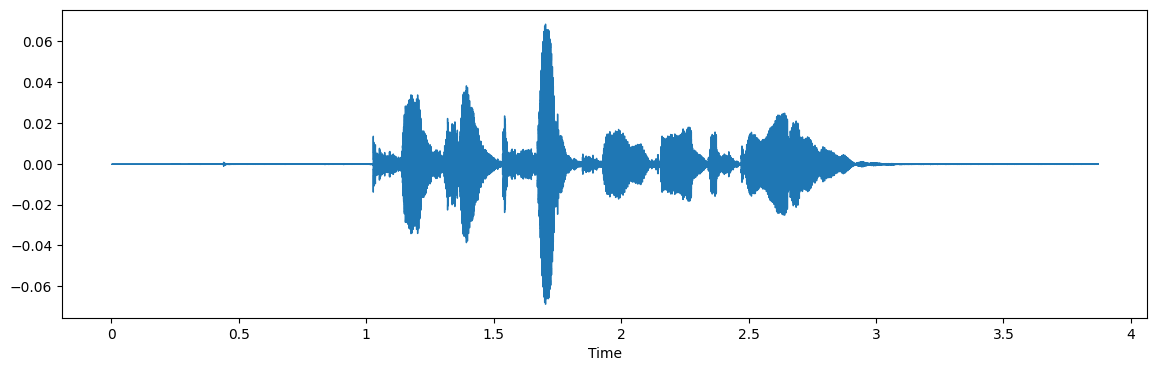

In [ ]:
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=data, sr=sample_rate)
plt.title('Simple Audio')
Audio(path)

#### 2. Noise Injection

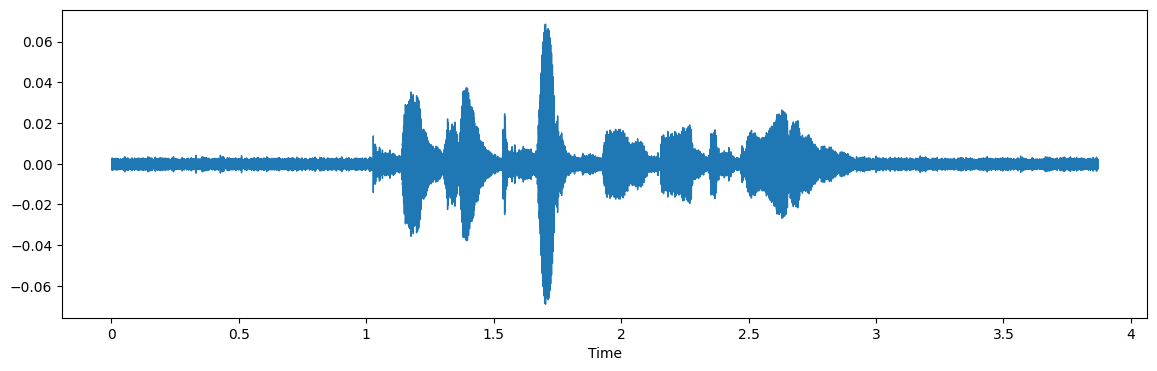

In [ ]:
x = augmenter.add_noise(data.copy())
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
plt.title('Noise Injection')
Audio(x, rate=sample_rate)

We can see noise injection is a very good augmentation technique because of which we can assure our training model is not overfitted

#### 3. Stretching

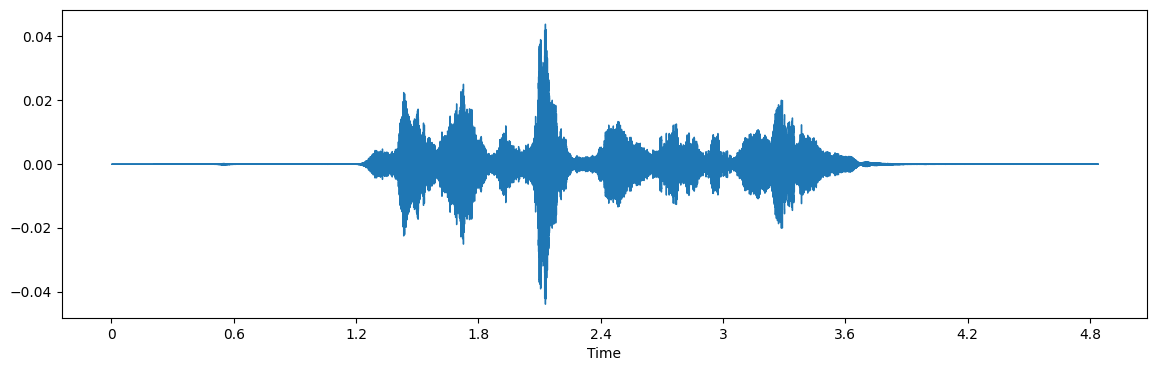

In [ ]:
x = augmenter.stretch_audio(data.copy())
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
plt.title('Stretching')
Audio(x, rate=sample_rate)

#### 4. Shifting

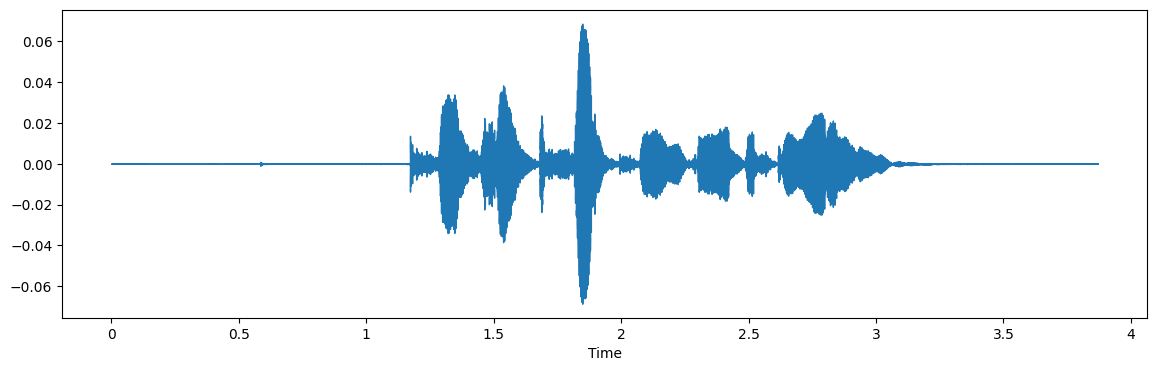

In [ ]:
x = np.roll(data.copy(), 3000)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
plt.title('Shifting')
Audio(x, rate=sample_rate)

#### 5. Pitch

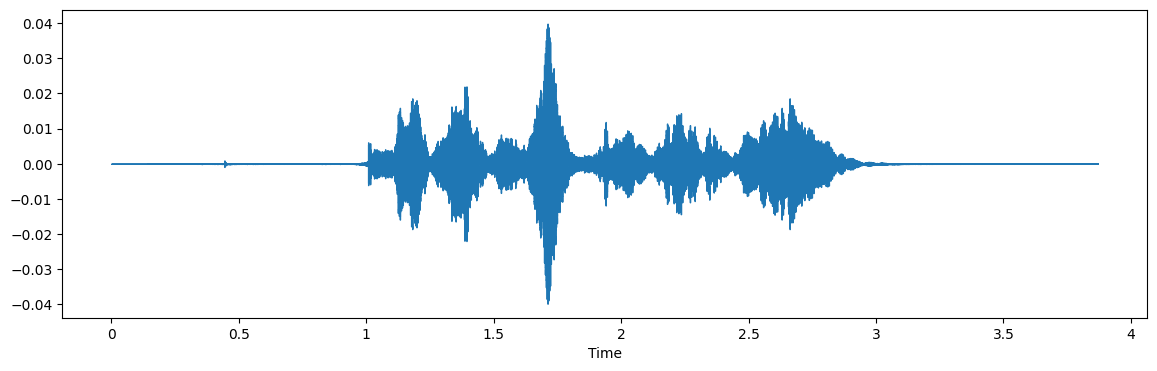

In [ ]:
x = augmenter.shift_pitch(data.copy(), sample_rate)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
plt.title('Pitch')
Audio(x, rate=sample_rate)

In [ ]:
class AudioFeatureProcessor:
    def compute_acoustic_features(self, audio_signal, sample_freq):
        feature_vector = np.array([])

        # Time-domain characteristics
        temporal_crossings = np.mean(librosa.feature.zero_crossing_rate(y=audio_signal).T, axis=0)
        feature_vector = np.hstack((feature_vector, temporal_crossings))

        # Spectral characteristics
        spectral_transform = np.abs(librosa.stft(audio_signal))
        tonal_features = np.mean(librosa.feature.chroma_stft(S=spectral_transform, sr=sample_freq).T, axis=0)
        feature_vector = np.hstack((feature_vector, tonal_features))

        # Cepstral coefficients
        cepstral_features = np.mean(librosa.feature.mfcc(y=audio_signal, sr=sample_freq).T, axis=0)
        feature_vector = np.hstack((feature_vector, cepstral_features))

        # Energy characteristics
        energy_profile = np.mean(librosa.feature.rms(y=audio_signal).T, axis=0)
        feature_vector = np.hstack((feature_vector, energy_profile))

        # Frequency-band characteristics
        spectral_bands = np.mean(librosa.feature.melspectrogram(y=audio_signal, sr=sample_freq).T, axis=0)
        feature_vector = np.hstack((feature_vector, spectral_bands))

        return feature_vector

    def process_audio_file(self, audio_path):
        # Load with consistent duration
        audio_signal, sample_freq = librosa.load(audio_path, duration=2.5, offset=0.6)

        # Original features
        base_features = self.compute_acoustic_features(audio_signal, sample_freq)
        combined_features = np.array(base_features)

        # Augmented variations
        noisy_signal = augmenter.add_noise(audio_signal.copy())
        noise_features = self.compute_acoustic_features(noisy_signal, sample_freq)
        combined_features = np.vstack((combined_features, noise_features))

        # Combined augmentation
        modified_signal = augmenter.stretch_audio(audio_signal.copy())
        pitch_modified = augmenter.shift_pitch(modified_signal, sample_freq)
        combined_features = np.vstack((combined_features,
                                     self.compute_acoustic_features(pitch_modified, sample_freq)))

        return combined_features

In [ ]:
feature_processor = AudioFeatureProcessor()
acoustic_features, emotional_labels = [], []

for audio_path, emotion_label in zip(Ravdess_df.Path, Ravdess_df.Emotions):
    audio_features = feature_processor.process_audio_file(audio_path)
    for feature_set in audio_features:
        acoustic_features.append(feature_set)
        emotional_labels.append(emotion_label)

In [ ]:
len(acoustic_features), len(emotional_labels), data_path.Path.shape

(4320, 4320, (1440,))

In [ ]:
Features = pd.DataFrame(acoustic_features)
Features['labels'] = emotional_labels
Features.to_csv('features.csv', index=False)
Features.head()

0         1         2         3         4         5         6  \
0  0.207714  0.597144  0.492776  0.471537  0.484861  0.475372  0.473590   
1  0.315036  0.721798  0.686010  0.702532  0.725444  0.717059  0.634275   
2  0.170931  0.688605  0.605986  0.500057  0.454000  0.462201  0.449220   
3  0.227114  0.552903  0.542117  0.591258  0.581472  0.559128  0.547762   
4  0.235040  0.615885  0.607224  0.630799  0.635577  0.624461  0.611855   

          7         8         9  ...       153       154       155       156  \
0  0.494506  0.508687  0.579848  ...  0.000108  0.000224  0.000188  0.000196   
1  0.623960  0.639274  0.689946  ...  0.000512  0.000667  0.000620  0.000644   
2  0.473260  0.465937  0.476708  ...  0.000035  0.000017  0.000029  0.000058   
3  0.522931  0.524957  0.526222  ...  0.000227  0.000071  0.000058  0.000077   
4  0.574705  0.572210  0.564244  ...  0.000244  0.000090  0.000076  0.000092   

        157       158       159       160           161  labels  
0  0.000106  0.000147  0.000083  0.000044  5.619653e-06     sad  
1  0.000541  0.000607  0.000521  0.000482  4.311776e-04     sad  
2  0.000030  0.000021  0.000019  0.000019  8.230168e-07     sad  
3  0.000127  0.000178  0.000182  0.000128  9.736709e-06    calm  
4  0.000139  0.000197  0.000202  0.000145  2.778353e-05    calm  

[5 rows x 163 columns]

* We have applied data augmentation and extracted the features for each audio files and saved them.

## Data Preparation

- As of now we have extracted the data, now we need to normalize and split our data for training and testing.

In [2]:
# Cell: Data Preparation Class
class EmotionDataPreprocessor:
    def __init__(self, feature_data):
        self.feature_data = feature_data
        self.feature_scaler = StandardScaler()
        self.label_encoder = OneHotEncoder(sparse=False)

    def prepare_model_data(self):
        # Split features and labels
        acoustic_data = self.feature_data.iloc[:, :-1].values
        emotion_labels = self.feature_data['labels'].values.reshape(-1, 1)

        # Encode emotional labels
        encoded_labels = self.label_encoder.fit_transform(emotion_labels)

        # Split into training and test sets
        x_train, x_test, y_train, y_test = train_test_split(
            acoustic_data, encoded_labels, random_state=0, shuffle=True
        )

        # Scale features
        x_train = self.feature_scaler.fit_transform(x_train)
        x_test = self.feature_scaler.transform(x_test)

        # Reshape for CNN (keeping original dimensions)
        x_train = np.expand_dims(x_train, axis=2)
        x_test = np.expand_dims(x_test, axis=2)

        return x_train, x_test, y_train, y_test

In [ ]:
data_processor = EmotionDataPreprocessor(Features)
x_train, x_test, y_train, y_test = data_processor.prepare_model_data()
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3240, 162), (3240, 8), (1080, 162), (1080, 8))

## Modelling

In [3]:
def create_emotion_recognition_model(input_shape):
    network = Sequential([
        # Input processing layer
        Conv1D(256, kernel_size=5, strides=1, padding='same',
               activation='relu', input_shape=input_shape,
               name='acoustic_input'),
        BatchNormalization(name='norm1'),
        MaxPooling1D(pool_size=5, strides=2, padding='same',
                    name='pool1'),

        # Feature extraction layers
        Conv1D(256, kernel_size=5, strides=1, padding='same',
               activation='relu', name='conv2'),
        BatchNormalization(name='norm2'),
        MaxPooling1D(pool_size=5, strides=2, padding='same',
                    name='pool2'),

        # Pattern recognition layers
        Conv1D(128, kernel_size=5, strides=1, padding='same',
               activation='relu', name='conv3'),
        MaxPooling1D(pool_size=5, strides=2, padding='same',
                    name='pool3'),
        Dropout(0.2, name='drop1'),

        # Final feature extraction
        Conv1D(64, kernel_size=5, strides=1, padding='same',
               activation='relu', name='conv4'),
        MaxPooling1D(pool_size=5, strides=2, padding='same',
                    name='pool4'),

        # Classification layers
        Flatten(name='flatten'),
        Dense(32, activation='relu', name='dense1'),
        Dropout(0.3, name='drop2'),
        Dense(8, activation='softmax', name='emotion_output')
    ])

    network.compile(optimizer='adam',
                   loss='categorical_crossentropy',
                   metrics=['accuracy'])
    return network

In [ ]:
model = create_emotion_recognition_model((x_train.shape[1], 1))

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 162, 256)            │           1,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 81, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 81, 256)             │         327,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 41, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 41, 128)             │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_2 (MaxPooling1D)       │ (None, 21, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 21, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_3 (Conv1D)                    │ (None, 21, 64)              │          41,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_3 (MaxPooling1D)       │ (None, 11, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 704)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │          22,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 8)                   │             264 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 557,288 (2.13 MB)

 Trainable params: 557,288 (2.13 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
learning_rate_reducer = ReduceLROnPlateau(monitor='loss', factor=0.4,
                                        verbose=0, patience=2,
                                        min_lr=0.0000001)
history = model.fit(x_train, y_train, batch_size=64, epochs=50,
                   validation_data=(x_test, y_test),
                   callbacks=[learning_rate_reducer])

Epoch 1/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 28s 471ms/step - accuracy: 0.1710 - loss: 2.0128 - val_accuracy: 0.2648 - val_loss: 1.8996 - learning_rate: 0.0010
Epoch 2/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 32s 626ms/step - accuracy: 0.2168 - loss: 1.9203 - val_accuracy: 0.3019 - val_loss: 1.8624 - learning_rate: 0.0010
Epoch 3/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 32s 445ms/step - accuracy: 0.2505 - loss: 1.8936 - val_accuracy: 0.2907 - val_loss: 1.7947 - learning_rate: 0.0010
Epoch 4/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 24s 469ms/step - accuracy: 0.2853 - loss: 1.8183 - val_accuracy: 0.3343 - val_loss: 1.7594 - learning_rate: 0.0010
Epoch 5/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 40s 447ms/step - accuracy: 0.3223 - loss: 1.7717 - val_accuracy: 0.3157 - val_loss: 1.7666 - learning_rate: 0.0010
Epoch 6/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 27s 540ms/step - accuracy: 0.3217 - loss: 1.7265 - val_accuracy: 0.3463 - val_loss: 1.6534 - learning_rate: 0.0010
Epoch 7/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 36s 438ms/step - accuracy: 0.3313 - loss: 1.

In [ ]:

class EmotionModelVisualizer:
    def __init__(self, training_history, encoder):
        self.history = training_history
        self.label_encoder = encoder

    def plot_training_metrics(self):
        training_epochs = list(range(len(self.history.history['accuracy'])))
        fig, (loss_ax, acc_ax) = plt.subplots(1, 2, figsize=(20, 6))


        loss_ax.plot(training_epochs, self.history.history['loss'],
                    label='Training Loss')
        loss_ax.plot(training_epochs, self.history.history['val_loss'],
                    label='Testing Loss')
        loss_ax.set_title('Training & Testing Loss')
        loss_ax.legend()
        loss_ax.set_xlabel("Epochs")


        acc_ax.plot(training_epochs, self.history.history['accuracy'],
                   label='Training Accuracy')
        acc_ax.plot(training_epochs, self.history.history['val_accuracy'],
                   label='Testing Accuracy')
        acc_ax.set_title('Training & Testing Accuracy')
        acc_ax.legend()
        acc_ax.set_xlabel("Epochs")
        plt.show()

    def create_confusion_matrix(self, y_true, y_pred):
        confusion_mat = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(12, 10))

        confusion_df = pd.DataFrame(
            confusion_mat,
            index=[i for i in self.label_encoder.categories_[0]],
            columns=[i for i in self.label_encoder.categories_[0]]
        )

        sns.heatmap(confusion_df, linecolor='white', cmap='Blues',
                   linewidth=1, annot=True, fmt='')
        plt.title('Confusion Matrix', size=20)
        plt.xlabel('Predicted Labels', size=14)
        plt.ylabel('Actual Labels', size=14)
        plt.show()

34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.6401 - loss: 1.3936
Accuracy of our model on test data :  64.07407522201538 %


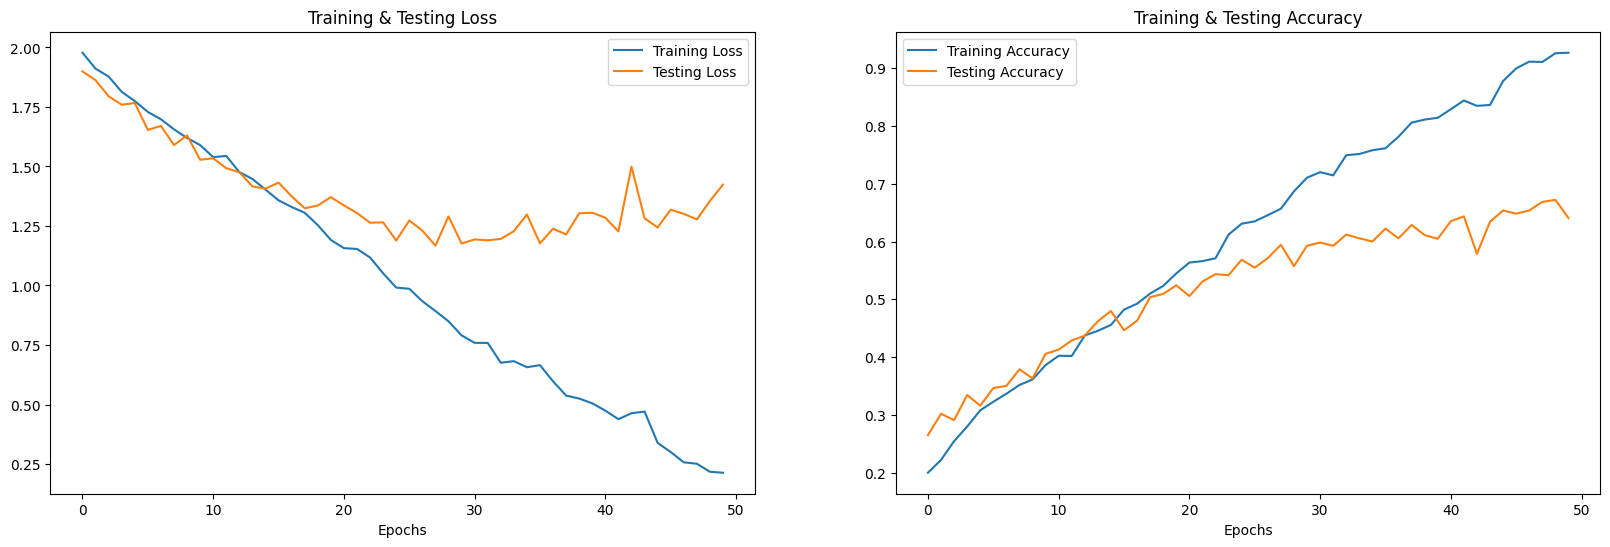

In [ ]:
print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")

visualizer = EmotionModelVisualizer(history, data_processor.label_encoder)
visualizer.plot_training_metrics()

In [ ]:

class EmotionModelAnalyzer:
    def __init__(self, trained_model, test_data, test_labels, encoder):
        self.model = trained_model
        self.test_data = test_data
        self.test_labels = test_labels
        self.encoder = encoder

    def evaluate_performance(self):
        # Generate predictions
        predicted_probs = self.model.predict(self.test_data)
        predicted_emotions = self.encoder.inverse_transform(predicted_probs)
        actual_emotions = self.encoder.inverse_transform(self.test_labels)

        # Create results dataframe )
        results_df = pd.DataFrame({
            'Predicted Labels': predicted_emotions.flatten(),
            'Actual Labels': actual_emotions.flatten()
        })

        return results_df, predicted_emotions, actual_emotions

    def print_classification_metrics(self, y_true, y_pred):
        print(classification_report(y_true, y_pred))

In [ ]:
analyzer = EmotionModelAnalyzer(model, x_test, y_test, data_processor.label_encoder)
results_df, y_pred, y_test_true = analyzer.evaluate_performance()

In [ ]:
results_df.head(10)

Predicted Labels Actual Labels
0          disgust       disgust
1          disgust       disgust
2          neutral       neutral
3             calm          calm
4            angry           sad
5          neutral           sad
6            happy          fear
7              sad          fear
8             calm          calm
9            happy      surprise

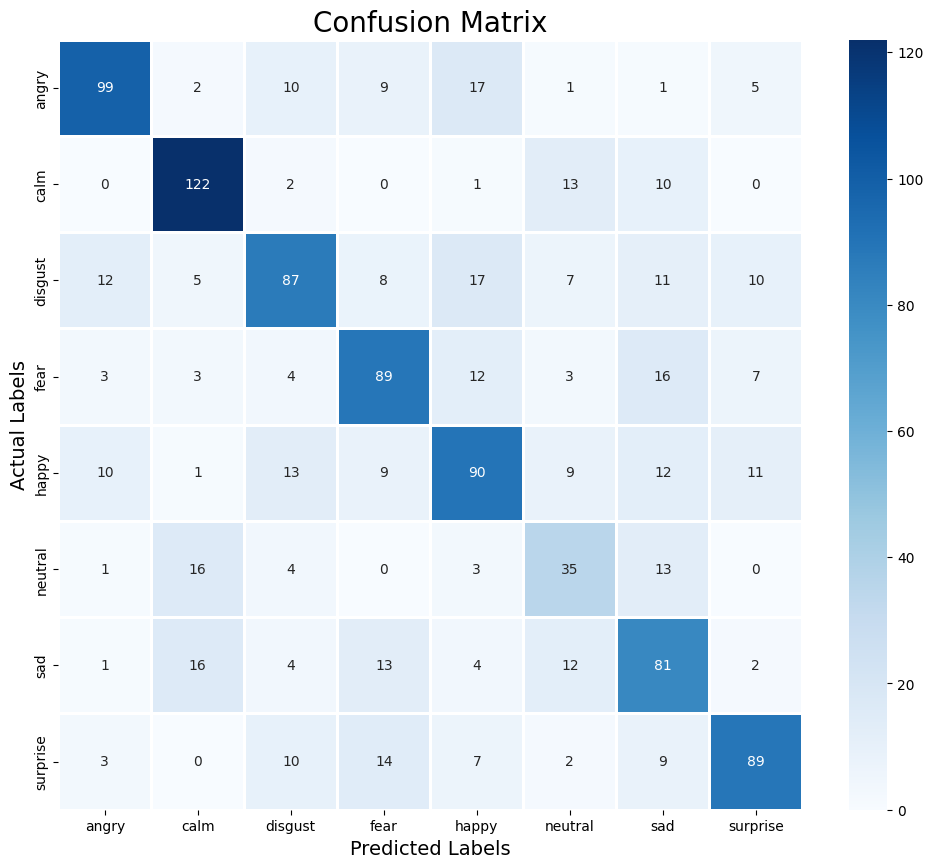

In [ ]:
visualizer.create_confusion_matrix(y_test_true, y_pred)

In [ ]:
analyzer.print_classification_metrics(y_test_true, y_pred)

              precision    recall  f1-score   support

       angry       0.77      0.69      0.73       144
        calm       0.74      0.82      0.78       148
     disgust       0.65      0.55      0.60       157
        fear       0.63      0.65      0.64       137
       happy       0.60      0.58      0.59       155
     neutral       0.43      0.49      0.45        72
         sad       0.53      0.61      0.57       133
    surprise       0.72      0.66      0.69       134

    accuracy                           0.64      1080
   macro avg       0.63      0.63      0.63      1080
weighted avg       0.65      0.64      0.64      1080

